In [1]:
import numpy as np
import pycbc.conversions as pc
import pycbc.pnutils as pnu
import pandas as pd
import h5py, os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sys
from lal import YRJUL_SI

def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
            
    return ans


def print_some_rcParams():
    rc_keys = ['backend', 'axes.labelsize', 'axes.titlesize', 'font.size',
        'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize', 'font.family',
        'text.usetex', 'figure.figsize'] # 'font.sans-serif', 'font.serif'
    print('Using the following matplotlib settings:')
    for k in rc_keys:
        print(k, ':', plt.rcParams[k])

# Figure size, font and color settings
inline_rc = dict(mpl.rcParams)

cat10 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
'#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
try:
    from cycler import cycler
    prop_cycle = cycler('color', cat10)
    plt.rc('axes', prop_cycle=prop_cycle)
except:
    plt.rc('axes', color_cycle=cat10)
    pass

rc_params_O1 = {'backend': 'pdf',
             'axes.labelsize': 15,
             'axes.titlesize': 15,
             'font.size': 15,
             'legend.fontsize': 12,
             'xtick.labelsize': 15,
             'ytick.labelsize': 15,
             'font.family': 'serif',
             'font.serif': ['Palatino'],
             'font.weight': "bold",
             'text.usetex':True
            }

# Figure out figure size to avoid rescaling in the document
column_width = 246.0
inches_per_pt = 1.0/72.27
fig_width = column_width * inches_per_pt
rc_params_O1['figure.figsize'] = (fig_width, fig_width/1.6)
rc_params_O1['figure.dpi'] = 300
rc_params_O1['savefig.dpi'] = 300

plt.rcParams.update(rc_params_O1)

In [2]:
## Source frame injection limits
m1_min=0.19
m1_max=11.0
m2_min=0.19
m2_max=1.1
z_max = 0.2

q_max = 20.
m1_bins = [0.19, 2.67, 4.53, 6.49, 8.63, 11.]
m2_bins = [0.19, 0.43, 0.62, 0.78, 0.94, 1.1]
mc_bins = [0.16, 0.44, 0.73, 1.01, 1.3, 1.58, 1.87, 2.15, 2.44, 2.72]


ifar_threshold = 10 ## yr 

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

In [4]:
injection_file = '/home/bhooshan.gadre/work/O3/sub_solar_search/O3B_VTs/ssm-search/O3b_VTs/common_ssm_injections.hdf'
injections = load_dict_from_hdf5(injection_file)
injections.keys(), len(injections.keys())

(dict_keys(['coa_phase', 'declination', 'distance', 'gstlal_ifar', 'gstlal_weight', 'inclination', 'mass1_source', 'mass2_source', 'mbta_ifar', 'polarization', 'pycbc_ifar', 'right_ascension', 'snr_H', 'snr_L', 'snr_V', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'time']),
 22)

In [5]:
opt_snr = injections['snr_H']**2. + injections['snr_L']**2. + injections['snr_V']**2. 
injections['opt_snr'] = np.sqrt(opt_snr) 
injections.keys(), len(injections.keys())

(dict_keys(['coa_phase', 'declination', 'distance', 'gstlal_ifar', 'gstlal_weight', 'inclination', 'mass1_source', 'mass2_source', 'mbta_ifar', 'polarization', 'pycbc_ifar', 'right_ascension', 'snr_H', 'snr_L', 'snr_V', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'time', 'opt_snr']),
 23)

In [6]:
df = pd.DataFrame(injections)
df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,opt_snr
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.0,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09,4.068939
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.0,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,4.209951
2,5.447231,-1.440067,302.357273,0.0,0.666667,0.854144,10.481894,1.045793,0.0,0.132165,0.0,2.621765,4.408046,6.731172,1.315282,-0.004171,-0.046270,0.012784,0.021928,-0.027524,-0.030501,1.238166e+09,8.152884
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.0,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09,4.160354
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.0,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,4.043672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.0,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,4.263212
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.0,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09,5.863658
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.0,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09,4.324439
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.0,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09,4.844654


In [7]:
# add chirpmass column
df['chirp_mass'] = ( (df['mass1_source'] * df['mass2_source'])**(3/5) ) / ( ( df['mass1_source'] + df['mass2_source'] )**(1/5) ) 

In [8]:
df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,opt_snr,chirp_mass
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.0,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09,4.068939,0.774597
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.0,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,4.209951,1.750252
2,5.447231,-1.440067,302.357273,0.0,0.666667,0.854144,10.481894,1.045793,0.0,0.132165,0.0,2.621765,4.408046,6.731172,1.315282,-0.004171,-0.046270,0.012784,0.021928,-0.027524,-0.030501,1.238166e+09,8.152884,2.579781
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.0,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09,4.160354,2.079797
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.0,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,4.043672,1.890638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.0,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,4.263212,1.397794
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.0,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09,5.863658,2.134303
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.0,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09,4.324439,2.075954
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.0,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09,4.844654,1.817291


In [9]:
df_m = df_p = df
df_g = df[df['gstlal_weight'] == 1.000000]

In [10]:
df['chirp_mass'].describe()

count    1.916583e+06
mean     1.462101e+00
std      5.096730e-01
min      1.699187e-01
25%      1.065911e+00
50%      1.437954e+00
75%      1.844115e+00
max      2.710091e+00
Name: chirp_mass, dtype: float64

# Analysis with chirp mass

In [11]:
# filter dataframe
df = df[(df['chirp_mass'] >= 0.17) & (df['chirp_mass'] <= 2.39)]
df_g = df_g[(df_g['chirp_mass'] >= 0.17) & (df_g['chirp_mass'] <= 2.39)]

In [12]:
df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,opt_snr,chirp_mass
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.000000,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09,4.068939,0.774597
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.000000,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,4.209951,1.750252
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.000000,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09,4.160354,2.079797
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.000000,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,4.043672,1.890638
5,0.868835,0.147375,295.312511,0.0,0.666667,0.260258,3.702428,0.499850,0.000003,2.970713,0.0,4.691473,3.670608,2.929989,1.331404,-0.052888,0.076367,0.013991,-0.004732,-0.001651,-0.000819,1.238166e+09,4.881684,1.085673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.000000,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,4.263212,1.397794
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.000000,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09,5.863658,2.134303
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.000000,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09,4.324439,2.075954
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.000000,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09,4.844654,1.817291


In [13]:
df_g

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,opt_snr,chirp_mass
1,0.673478,-0.622410,458.599031,0.0,1.0,0.918732,6.421466,0.763863,0.000000e+00,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,4.209951,1.750252
4,0.183151,-0.734805,833.927353,0.0,1.0,2.895566,7.129897,0.808812,0.000000e+00,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,4.043672,1.890638
7,1.993550,-0.260465,488.862832,0.0,1.0,2.332464,8.636446,0.420814,0.000000e+00,0.206436,0.0,2.733766,3.672848,5.026132,0.952871,-0.031718,-0.045808,0.064866,0.000128,-0.000065,0.000301,1.238166e+09,6.297601,1.395904
10,3.356570,-0.805484,433.718836,0.0,1.0,2.453931,10.508717,0.269122,0.000000e+00,2.014318,0.0,2.780945,2.717438,2.735633,1.377310,-0.048021,0.017748,0.034907,-0.002367,0.004690,-0.000318,1.238166e+09,4.094526,1.159826
13,2.723905,-0.909426,410.483008,0.0,1.0,2.370470,3.218973,0.706197,1.130063e-09,1.393210,0.0,1.395882,4.397573,5.849438,0.762903,0.030845,0.010951,-0.028765,0.071988,-0.058108,-0.019227,1.238166e+09,7.357757,1.245129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916569,5.536838,1.092579,496.300098,0.0,1.0,1.152792,8.155087,0.915510,0.000000e+00,2.368460,0.0,1.291601,3.169196,3.796076,1.034902,-0.013244,-0.001974,-0.028839,0.001049,0.021523,-0.076808,1.269561e+09,5.052229,2.149452
1916572,4.042693,-0.601940,336.873980,0.0,1.0,2.181383,3.530335,0.956817,0.000000e+00,0.405525,0.0,4.728817,2.675803,3.185187,1.203063,0.001638,0.002812,0.002323,0.002218,0.013861,0.016641,1.269561e+09,4.330439,1.537421
1916575,4.375681,-0.482808,571.785549,0.0,1.0,0.630822,7.595975,0.770182,0.000000e+00,1.279978,0.0,5.800984,3.672192,3.866309,0.186591,0.032819,0.002505,0.004759,0.004555,-0.059240,0.016644,1.269562e+09,5.335556,1.887127
1916578,0.187059,-0.469964,752.284246,0.0,1.0,0.388063,5.784159,0.559250,0.000000e+00,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,4.263212,1.397794


In [14]:
# divide the dataframe into 9 equally spaced intervals
df['interval'] = pd.cut(df['chirp_mass'], bins=9, labels = False)
df_g['interval'] = pd.cut(df_g['chirp_mass'], bins=9, labels = False)

/tmp/ipykernel_2951299/568848010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interval'] = pd.cut(df['chirp_mass'], bins=9, labels = False)


In [15]:
df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,opt_snr,chirp_mass,interval
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.000000,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09,4.068939,0.774597,2
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.000000,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,4.209951,1.750252,6
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.000000,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09,4.160354,2.079797,7
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.000000,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,4.043672,1.890638,6
5,0.868835,0.147375,295.312511,0.0,0.666667,0.260258,3.702428,0.499850,0.000003,2.970713,0.0,4.691473,3.670608,2.929989,1.331404,-0.052888,0.076367,0.013991,-0.004732,-0.001651,-0.000819,1.238166e+09,4.881684,1.085673,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.000000,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,4.263212,1.397794,4
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.000000,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09,5.863658,2.134303,7
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.000000,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09,4.324439,2.075954,7
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.000000,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09,4.844654,1.817291,6


In [16]:
df_g

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,opt_snr,chirp_mass,interval
1,0.673478,-0.622410,458.599031,0.0,1.0,0.918732,6.421466,0.763863,0.000000e+00,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,4.209951,1.750252,6
4,0.183151,-0.734805,833.927353,0.0,1.0,2.895566,7.129897,0.808812,0.000000e+00,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,4.043672,1.890638,6
7,1.993550,-0.260465,488.862832,0.0,1.0,2.332464,8.636446,0.420814,0.000000e+00,0.206436,0.0,2.733766,3.672848,5.026132,0.952871,-0.031718,-0.045808,0.064866,0.000128,-0.000065,0.000301,1.238166e+09,6.297601,1.395904,4
10,3.356570,-0.805484,433.718836,0.0,1.0,2.453931,10.508717,0.269122,0.000000e+00,2.014318,0.0,2.780945,2.717438,2.735633,1.377310,-0.048021,0.017748,0.034907,-0.002367,0.004690,-0.000318,1.238166e+09,4.094526,1.159826,4
13,2.723905,-0.909426,410.483008,0.0,1.0,2.370470,3.218973,0.706197,1.130063e-09,1.393210,0.0,1.395882,4.397573,5.849438,0.762903,0.030845,0.010951,-0.028765,0.071988,-0.058108,-0.019227,1.238166e+09,7.357757,1.245129,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916569,5.536838,1.092579,496.300098,0.0,1.0,1.152792,8.155087,0.915510,0.000000e+00,2.368460,0.0,1.291601,3.169196,3.796076,1.034902,-0.013244,-0.001974,-0.028839,0.001049,0.021523,-0.076808,1.269561e+09,5.052229,2.149452,8
1916572,4.042693,-0.601940,336.873980,0.0,1.0,2.181383,3.530335,0.956817,0.000000e+00,0.405525,0.0,4.728817,2.675803,3.185187,1.203063,0.001638,0.002812,0.002323,0.002218,0.013861,0.016641,1.269561e+09,4.330439,1.537421,5
1916575,4.375681,-0.482808,571.785549,0.0,1.0,0.630822,7.595975,0.770182,0.000000e+00,1.279978,0.0,5.800984,3.672192,3.866309,0.186591,0.032819,0.002505,0.004759,0.004555,-0.059240,0.016644,1.269562e+09,5.335556,1.887127,6
1916578,0.187059,-0.469964,752.284246,0.0,1.0,0.388063,5.784159,0.559250,0.000000e+00,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,4.263212,1.397794,4


In [17]:
df['interval'].value_counts()

4    318632
5    306408
3    304463
6    270484
7    213980
2    197888
8    143224
1     80226
0     13071
Name: interval, dtype: int64

In [18]:
# iterate over the intervals and create the corresponding data frames.
for i in range(9):
    globals()[f"df_{i+1}"] = df[df['interval'] == i+1].copy()
    globals()[f"df_g_{i+1}"] = df_g[df_g['interval'] == i+1].copy()

In [19]:
sensitivity_p = []
sensitivity_m = []
sensitivity_g = []

list_har_ifar_mp_found = []
list_har_ifar_mg_found = []
list_har_ifar_pg_found = []
list_har_ifar_pgm_found = []

list_trial_ifar_pm_found = []
list_trial_ifar_mg_found = []
list_trial_ifar_pg_found = []
list_trial_ifar_pgm_found = []

def calculate_values(df_1, df_g_1, ifar_threshold):
    pfound = (df_1['pycbc_ifar'] >= ifar_threshold)
    mfound = (df_1['mbta_ifar'] >= ifar_threshold)
    gfound = (df_1['gstlal_ifar'] >= ifar_threshold)

    
    found_gm = (mfound * gfound) 
    found_gp = (pfound * gfound) 
    found_mp = (pfound * mfound) 

    found_ifar = found_gm + found_gp + found_mp
    print("*************************************************************\n")
    print('pfound =',pfound.sum(), ', mfound =',mfound.sum(), ', gfound =',gfound.sum(), ', found_ifar =',found_ifar.sum())
    print('found_gm =',found_gm.sum(), ', found_gp =',found_gp.sum(), ', found_mp =',found_mp.sum(), ', pfound * mfound * gfound =', (pfound * mfound * gfound).sum(), '\n')
    print("*************************************************************\n")
    print("Sensitibity pycbc")
    print(100*(pfound.sum()/len(df_1)))
    sensitivity_p.append(100*(pfound.sum()/len(df_1)))
    print("*************************************************************\n")
    print("Sensitibity mbta")
    print(100*(mfound.sum()/len(df_1)))
    sensitivity_m.append(100*(mfound.sum()/len(df_1)))
    print("*************************************************************\n")
    print("Sensitibity gstlal")
    print(100* (gfound.sum()/len(df_g_1)))
    sensitivity_g.append(100* (gfound.sum()/len(df_g_1)))
    print("*************************************************************\n")
    print("Harmonic case")
    har_ifar_mp = (1/2) * (df_1["pycbc_ifar"] + df_1["mbta_ifar"])
    har_ifar_mp_found = (har_ifar_mp >= ifar_threshold)
    print("har_ifar_mp_found = ", 100 * (har_ifar_mp_found.sum()/ len(df_1)))
    list_har_ifar_mp_found.append(100 * (har_ifar_mp_found.sum()/ len(df_1)))
    
    print("*************************************************************\n")
    har_ifar_mg = (1/2) * (df_g_1["mbta_ifar"] + df_g_1["gstlal_ifar"])
    har_ifar_mg_found = (har_ifar_mg >= ifar_threshold)
    print("har_ifar_mg_found = ", 100*(har_ifar_mg_found.sum()/ len(df_g_1)))
    list_har_ifar_mg_found.append(100*(har_ifar_mg_found.sum()/ len(df_g_1)))
    
    print("*************************************************************\n")
    har_ifar_pg = (1/2) * (df_g_1["pycbc_ifar"] + df_g_1["gstlal_ifar"])
    har_ifar_pg_found = (har_ifar_pg >= ifar_threshold)
    print("har_ifar_pg_found = ", 100*(har_ifar_pg_found.sum()/ len(df_g_1)))
    list_har_ifar_pg_found.append(100*(har_ifar_pg_found.sum()/ len(df_g_1)))
    
    print("*************************************************************\n")
    har_ifar_pgm = (1/3) * (df_g_1["pycbc_ifar"] + df_g_1["gstlal_ifar"] + df_g_1["mbta_ifar"])
    har_ifar_pgm_found = (har_ifar_pgm >= ifar_threshold)
    print("har_ifar_pgm_found = ", 100*(har_ifar_pgm_found.sum()/ len(df_g_1)))
    list_har_ifar_pgm_found.append(100*(har_ifar_pgm_found.sum()/ len(df_g_1)))
    
    print("*************************************************************\n")
    print("Trial case")
    trial_ifar_pm = (1/2) * df_1[["pycbc_ifar", "mbta_ifar"]].max(axis=1)
    trial_ifar_pm_found = (trial_ifar_pm >= ifar_threshold)
    print("trial_ifar_pm_found = ", 100*(trial_ifar_pm_found.sum()/ len(df_1)))
    list_trial_ifar_pm_found.append(100*(trial_ifar_pm_found.sum()/ len(df_1)))
    
    print("*************************************************************\n")
    trial_ifar_mg = (1/2) * df_g_1[["mbta_ifar", "gstlal_ifar"]].max(axis=1)
    trial_ifar_mg_found = (trial_ifar_mg >= ifar_threshold)
    print("trial_ifar_mg_found = ", 100*(trial_ifar_mg_found.sum()/ len(df_g_1)))
    list_trial_ifar_mg_found.append(100*(trial_ifar_mg_found.sum()/ len(df_g_1)))
    
    print("*************************************************************\n")
    trial_ifar_pg = (1/2) * df_g_1[["pycbc_ifar", "gstlal_ifar"]].max(axis=1)
    trial_ifar_pg_found = (trial_ifar_pg >= ifar_threshold)
    print("trial_ifar_pg_found = ", 100*(trial_ifar_pg_found.sum()/ len(df_g_1)))
    list_trial_ifar_pg_found.append(100*(trial_ifar_pg_found.sum()/ len(df_g_1)))
    
    print("*************************************************************\n")
    trial_ifar_pgm = (1/3) * df_g_1[["pycbc_ifar", "gstlal_ifar", "mbta_ifar"]].max(axis=1)
    trial_ifar_pgm_found = (trial_ifar_pgm >= ifar_threshold)
    print("trial_ifar_pgm_found = ", 100* (trial_ifar_pgm_found.sum()/ len(df_g_1)))
    list_trial_ifar_pgm_found.append(100* (trial_ifar_pgm_found.sum()/ len(df_g_1)))
    
    print("*************************************************************\n")
    return sensitivity_p, sensitivity_m, sensitivity_g, list_har_ifar_mp_found, list_har_ifar_mg_found, list_har_ifar_pg_found, list_har_ifar_pgm_found, list_trial_ifar_pm_found,list_trial_ifar_mg_found, list_trial_ifar_pg_found, list_trial_ifar_pgm_found 
    

In [20]:
calculate_values(df_1, df_g_1, 10)

*************************************************************

pfound = 3207 , mfound = 3193 , gfound = 1707 , found_ifar = 2260
found_gm = 704 , found_gp = 1197 , found_mp = 1631 , pfound * mfound * gfound = 636 

*************************************************************

Sensitibity pycbc
3.9974571834567345
*************************************************************

Sensitibity mbta
3.980006481689228
*************************************************************

Sensitibity gstlal
4.753550543024227
*************************************************************

Harmonic case
har_ifar_mp_found =  5.7612245406726
*************************************************************

har_ifar_mg_found =  6.574770258980784
*************************************************************

har_ifar_pg_found =  5.310498468393205
*************************************************************

har_ifar_pgm_found =  6.9033695349484825
*************************************************************

Tr

([3.9974571834567345],
 [3.980006481689228],
 [4.753550543024227],
 [5.7612245406726],
 [6.574770258980784],
 [5.310498468393205],
 [6.9033695349484825],
 [5.757485104579563],
 [6.574770258980784],
 [5.307713728766361],
 [6.900584795321637])

In [21]:
calculate_values(df_2, df_g_2, 10)

*************************************************************

pfound = 6715 , mfound = 6673 , gfound = 3805 , found_ifar = 4814
found_gm = 1534 , found_gp = 2579 , found_mp = 3371 , pfound * mfound * gfound = 1335 

*************************************************************

Sensitibity pycbc
3.393333602846054
*************************************************************

Sensitibity mbta
3.3721094760672705
*************************************************************

Sensitibity gstlal
4.288290318945114
*************************************************************

Harmonic case
har_ifar_mp_found =  4.921976067270375
*************************************************************

har_ifar_mg_found =  5.773695480671701
*************************************************************

har_ifar_pg_found =  4.696269581877606
*************************************************************

har_ifar_pgm_found =  6.021638679138961
*************************************************************


([3.9974571834567345, 3.393333602846054],
 [3.980006481689228, 3.3721094760672705],
 [4.753550543024227, 4.288290318945114],
 [5.7612245406726, 4.921976067270375],
 [6.574770258980784, 5.773695480671701],
 [5.310498468393205, 4.696269581877606],
 [6.9033695349484825, 6.021638679138961],
 [5.757485104579563, 4.917933376455369],
 [6.574770258980784, 5.773695480671701],
 [5.307713728766361, 4.687253465569706],
 [6.900584795321637, 6.01262256283106])

In [22]:
calculate_values(df_3, df_g_3, 10)

*************************************************************

pfound = 9444 , mfound = 8876 , gfound = 5519 , found_ifar = 6518
found_gm = 2090 , found_gp = 3669 , found_mp = 4477 , pfound * mfound * gfound = 1859 

*************************************************************

Sensitibity pycbc
3.1018547409701673
*************************************************************

Sensitibity mbta
2.915296768408641
*************************************************************

Sensitibity gstlal
4.04458645404312
*************************************************************

Harmonic case
har_ifar_mp_found =  4.414986385866263
*************************************************************

har_ifar_mg_found =  5.277236284755302
*************************************************************

har_ifar_pg_found =  4.392689111348879
*************************************************************

har_ifar_pgm_found =  5.507350462426898
*************************************************************



([3.9974571834567345, 3.393333602846054, 3.1018547409701673],
 [3.980006481689228, 3.3721094760672705, 2.915296768408641],
 [4.753550543024227, 4.288290318945114, 4.04458645404312],
 [5.7612245406726, 4.921976067270375, 4.414986385866263],
 [6.574770258980784, 5.773695480671701, 5.277236284755302],
 [5.310498468393205, 4.696269581877606, 4.392689111348879],
 [6.9033695349484825, 6.021638679138961, 5.507350462426898],
 [5.757485104579563, 4.917933376455369, 4.413015703057514],
 [6.574770258980784, 5.773695480671701, 5.27577058935612],
 [5.307713728766361, 4.687253465569706, 4.388292025151333],
 [6.900584795321637, 6.01262256283106, 5.4985562900318055])

In [23]:
calculate_values(df_4, df_g_4, 10)

*************************************************************

pfound = 10471 , mfound = 9900 , gfound = 6347 , found_ifar = 7390
found_gm = 2369 , found_gp = 4207 , found_mp = 4952 , pfound * mfound * gfound = 2069 

*************************************************************

Sensitibity pycbc
3.2862361595822143
*************************************************************

Sensitibity mbta
3.1070325642120067
*************************************************************

Sensitibity gstlal
4.453347553360183
*************************************************************

Harmonic case
har_ifar_mp_found =  4.699151372115795
*************************************************************

har_ifar_mg_found =  5.741569722569148
*************************************************************

har_ifar_pg_found =  4.729796101654482
*************************************************************

har_ifar_pgm_found =  5.938030619834131
************************************************************

([3.9974571834567345,
  3.393333602846054,
  3.1018547409701673,
  3.2862361595822143],
 [3.980006481689228,
  3.3721094760672705,
  2.915296768408641,
  3.1070325642120067],
 [4.753550543024227, 4.288290318945114, 4.04458645404312, 4.453347553360183],
 [5.7612245406726, 4.921976067270375, 4.414986385866263, 4.699151372115795],
 [6.574770258980784, 5.773695480671701, 5.277236284755302, 5.741569722569148],
 [5.310498468393205, 4.696269581877606, 4.392689111348879, 4.729796101654482],
 [6.9033695349484825, 6.021638679138961, 5.507350462426898, 5.938030619834131],
 [5.757485104579563, 4.917933376455369, 4.413015703057514, 4.696012955384267],
 [6.574770258980784, 5.773695480671701, 5.27577058935612, 5.740868076507486],
 [5.307713728766361, 4.687253465569706, 4.388292025151333, 4.722077994976214],
 [6.900584795321637, 6.01262256283106, 5.4985562900318055, 5.931014159217525])

In [24]:
calculate_values(df_5, df_g_5, 10)

*************************************************************

pfound = 10377 , mfound = 9831 , gfound = 6541 , found_ifar = 7548
found_gm = 2505 , found_gp = 4337 , found_mp = 5120 , pfound * mfound * gfound = 2207 

*************************************************************

Sensitibity pycbc
3.386660922691313
*************************************************************

Sensitibity mbta
3.208467141850082
*************************************************************

Sensitibity gstlal
4.780698869325615
*************************************************************

Harmonic case
har_ifar_mp_found =  4.790997624082922
*************************************************************

har_ifar_mg_found =  6.0275834849913394
*************************************************************

har_ifar_pg_found =  4.979498761155086
*************************************************************

har_ifar_pgm_found =  6.167912820400377
*************************************************************

([3.9974571834567345,
  3.393333602846054,
  3.1018547409701673,
  3.2862361595822143,
  3.386660922691313],
 [3.980006481689228,
  3.3721094760672705,
  2.915296768408641,
  3.1070325642120067,
  3.208467141850082],
 [4.753550543024227,
  4.288290318945114,
  4.04458645404312,
  4.453347553360183,
  4.780698869325615],
 [5.7612245406726,
  4.921976067270375,
  4.414986385866263,
  4.699151372115795,
  4.790997624082922],
 [6.574770258980784,
  5.773695480671701,
  5.277236284755302,
  5.741569722569148,
  6.0275834849913394],
 [5.310498468393205,
  4.696269581877606,
  4.392689111348879,
  4.729796101654482,
  4.979498761155086],
 [6.9033695349484825,
  6.021638679138961,
  5.507350462426898,
  5.938030619834131,
  6.167912820400377],
 [5.757485104579563,
  4.917933376455369,
  4.413015703057514,
  4.696012955384267,
  4.789039450667085],
 [6.574770258980784,
  5.773695480671701,
  5.27577058935612,
  5.740868076507486,
  6.023929075215062],
 [5.307713728766361,
  4.687253465569706,
 

In [25]:
calculate_values(df_6, df_g_6, 10)

*************************************************************

pfound = 9263 , mfound = 9095 , gfound = 5848 , found_ifar = 6816
found_gm = 2307 , found_gp = 3898 , found_mp = 4669 , pfound * mfound * gfound = 2029 

*************************************************************

Sensitibity pycbc
3.4246018248768877
*************************************************************

Sensitibity mbta
3.362490942162938
*************************************************************

Sensitibity gstlal
4.8208662390978185
*************************************************************

Harmonic case
har_ifar_mp_found =  4.924875408526937
*************************************************************

har_ifar_mg_found =  6.202496166718876
*************************************************************

har_ifar_pg_found =  5.054984914183964
*************************************************************

har_ifar_pgm_found =  6.312960612006001
*************************************************************

([3.9974571834567345,
  3.393333602846054,
  3.1018547409701673,
  3.2862361595822143,
  3.386660922691313,
  3.4246018248768877],
 [3.980006481689228,
  3.3721094760672705,
  2.915296768408641,
  3.1070325642120067,
  3.208467141850082,
  3.362490942162938],
 [4.753550543024227,
  4.288290318945114,
  4.04458645404312,
  4.453347553360183,
  4.780698869325615,
  4.8208662390978185],
 [5.7612245406726,
  4.921976067270375,
  4.414986385866263,
  4.699151372115795,
  4.790997624082922,
  4.924875408526937],
 [6.574770258980784,
  5.773695480671701,
  5.277236284755302,
  5.741569722569148,
  6.0275834849913394,
  6.202496166718876],
 [5.310498468393205,
  4.696269581877606,
  4.392689111348879,
  4.729796101654482,
  4.979498761155086,
  5.054984914183964],
 [6.9033695349484825,
  6.021638679138961,
  5.507350462426898,
  5.938030619834131,
  6.167912820400377,
  6.312960612006001],
 [5.757485104579563,
  4.917933376455369,
  4.413015703057514,
  4.696012955384267,
  4.789039450667085,


In [26]:
calculate_values(df_7, df_g_7, 10)

*************************************************************

pfound = 7528 , mfound = 7794 , gfound = 4735 , found_ifar = 5684
found_gm = 1920 , found_gp = 3107 , found_mp = 4015 , pfound * mfound * gfound = 1679 

*************************************************************

Sensitibity pycbc
3.51808580241144
*************************************************************

Sensitibity mbta
3.642396485652865
*************************************************************

Sensitibity gstlal
4.941608657990586
*************************************************************

Harmonic case
har_ifar_mp_found =  5.130386017384803
*************************************************************

har_ifar_mg_found =  6.379736795416358
*************************************************************

har_ifar_pg_found =  5.149291894091986
*************************************************************

har_ifar_pgm_found =  6.496623842870412
*************************************************************

T

([3.9974571834567345,
  3.393333602846054,
  3.1018547409701673,
  3.2862361595822143,
  3.386660922691313,
  3.4246018248768877,
  3.51808580241144],
 [3.980006481689228,
  3.3721094760672705,
  2.915296768408641,
  3.1070325642120067,
  3.208467141850082,
  3.362490942162938,
  3.642396485652865],
 [4.753550543024227,
  4.288290318945114,
  4.04458645404312,
  4.453347553360183,
  4.780698869325615,
  4.8208662390978185,
  4.941608657990586],
 [5.7612245406726,
  4.921976067270375,
  4.414986385866263,
  4.699151372115795,
  4.790997624082922,
  4.924875408526937,
  5.130386017384803],
 [6.574770258980784,
  5.773695480671701,
  5.277236284755302,
  5.741569722569148,
  6.0275834849913394,
  6.202496166718876,
  6.379736795416358],
 [5.310498468393205,
  4.696269581877606,
  4.392689111348879,
  4.729796101654482,
  4.979498761155086,
  5.054984914183964,
  5.149291894091986],
 [6.9033695349484825,
  6.021638679138961,
  5.507350462426898,
  5.938030619834131,
  6.167912820400377,
  

In [27]:
calculate_values(df_8, df_g_8, 10)

*************************************************************

pfound = 4866 , mfound = 5143 , gfound = 3051 , found_ifar = 3752
found_gm = 1316 , found_gp = 2021 , found_mp = 2721 , pfound * mfound * gfound = 1153 

*************************************************************

Sensitibity pycbc
3.3974752834720436
*************************************************************

Sensitibity mbta
3.590878623694353
*************************************************************

Sensitibity gstlal
4.767932489451477
*************************************************************

Harmonic case
har_ifar_mp_found =  4.965648215382896
*************************************************************

har_ifar_mg_found =  6.180653227066729
*************************************************************

har_ifar_pg_found =  4.957024535083606
*************************************************************

har_ifar_pgm_found =  6.274417877793405
*************************************************************


([3.9974571834567345,
  3.393333602846054,
  3.1018547409701673,
  3.2862361595822143,
  3.386660922691313,
  3.4246018248768877,
  3.51808580241144,
  3.3974752834720436],
 [3.980006481689228,
  3.3721094760672705,
  2.915296768408641,
  3.1070325642120067,
  3.208467141850082,
  3.362490942162938,
  3.642396485652865,
  3.590878623694353],
 [4.753550543024227,
  4.288290318945114,
  4.04458645404312,
  4.453347553360183,
  4.780698869325615,
  4.8208662390978185,
  4.941608657990586,
  4.767932489451477],
 [5.7612245406726,
  4.921976067270375,
  4.414986385866263,
  4.699151372115795,
  4.790997624082922,
  4.924875408526937,
  5.130386017384803,
  4.965648215382896],
 [6.574770258980784,
  5.773695480671701,
  5.277236284755302,
  5.741569722569148,
  6.0275834849913394,
  6.202496166718876,
  6.379736795416358,
  6.180653227066729],
 [5.310498468393205,
  4.696269581877606,
  4.392689111348879,
  4.729796101654482,
  4.979498761155086,
  5.054984914183964,
  5.149291894091986,
  4

In [28]:
#NOOOOOOO
#calculate_values(df_9, df_g_9, 10)

In [29]:
mass = [i for i in range(1,9)]
mass

[1, 2, 3, 4, 5, 6, 7, 8]

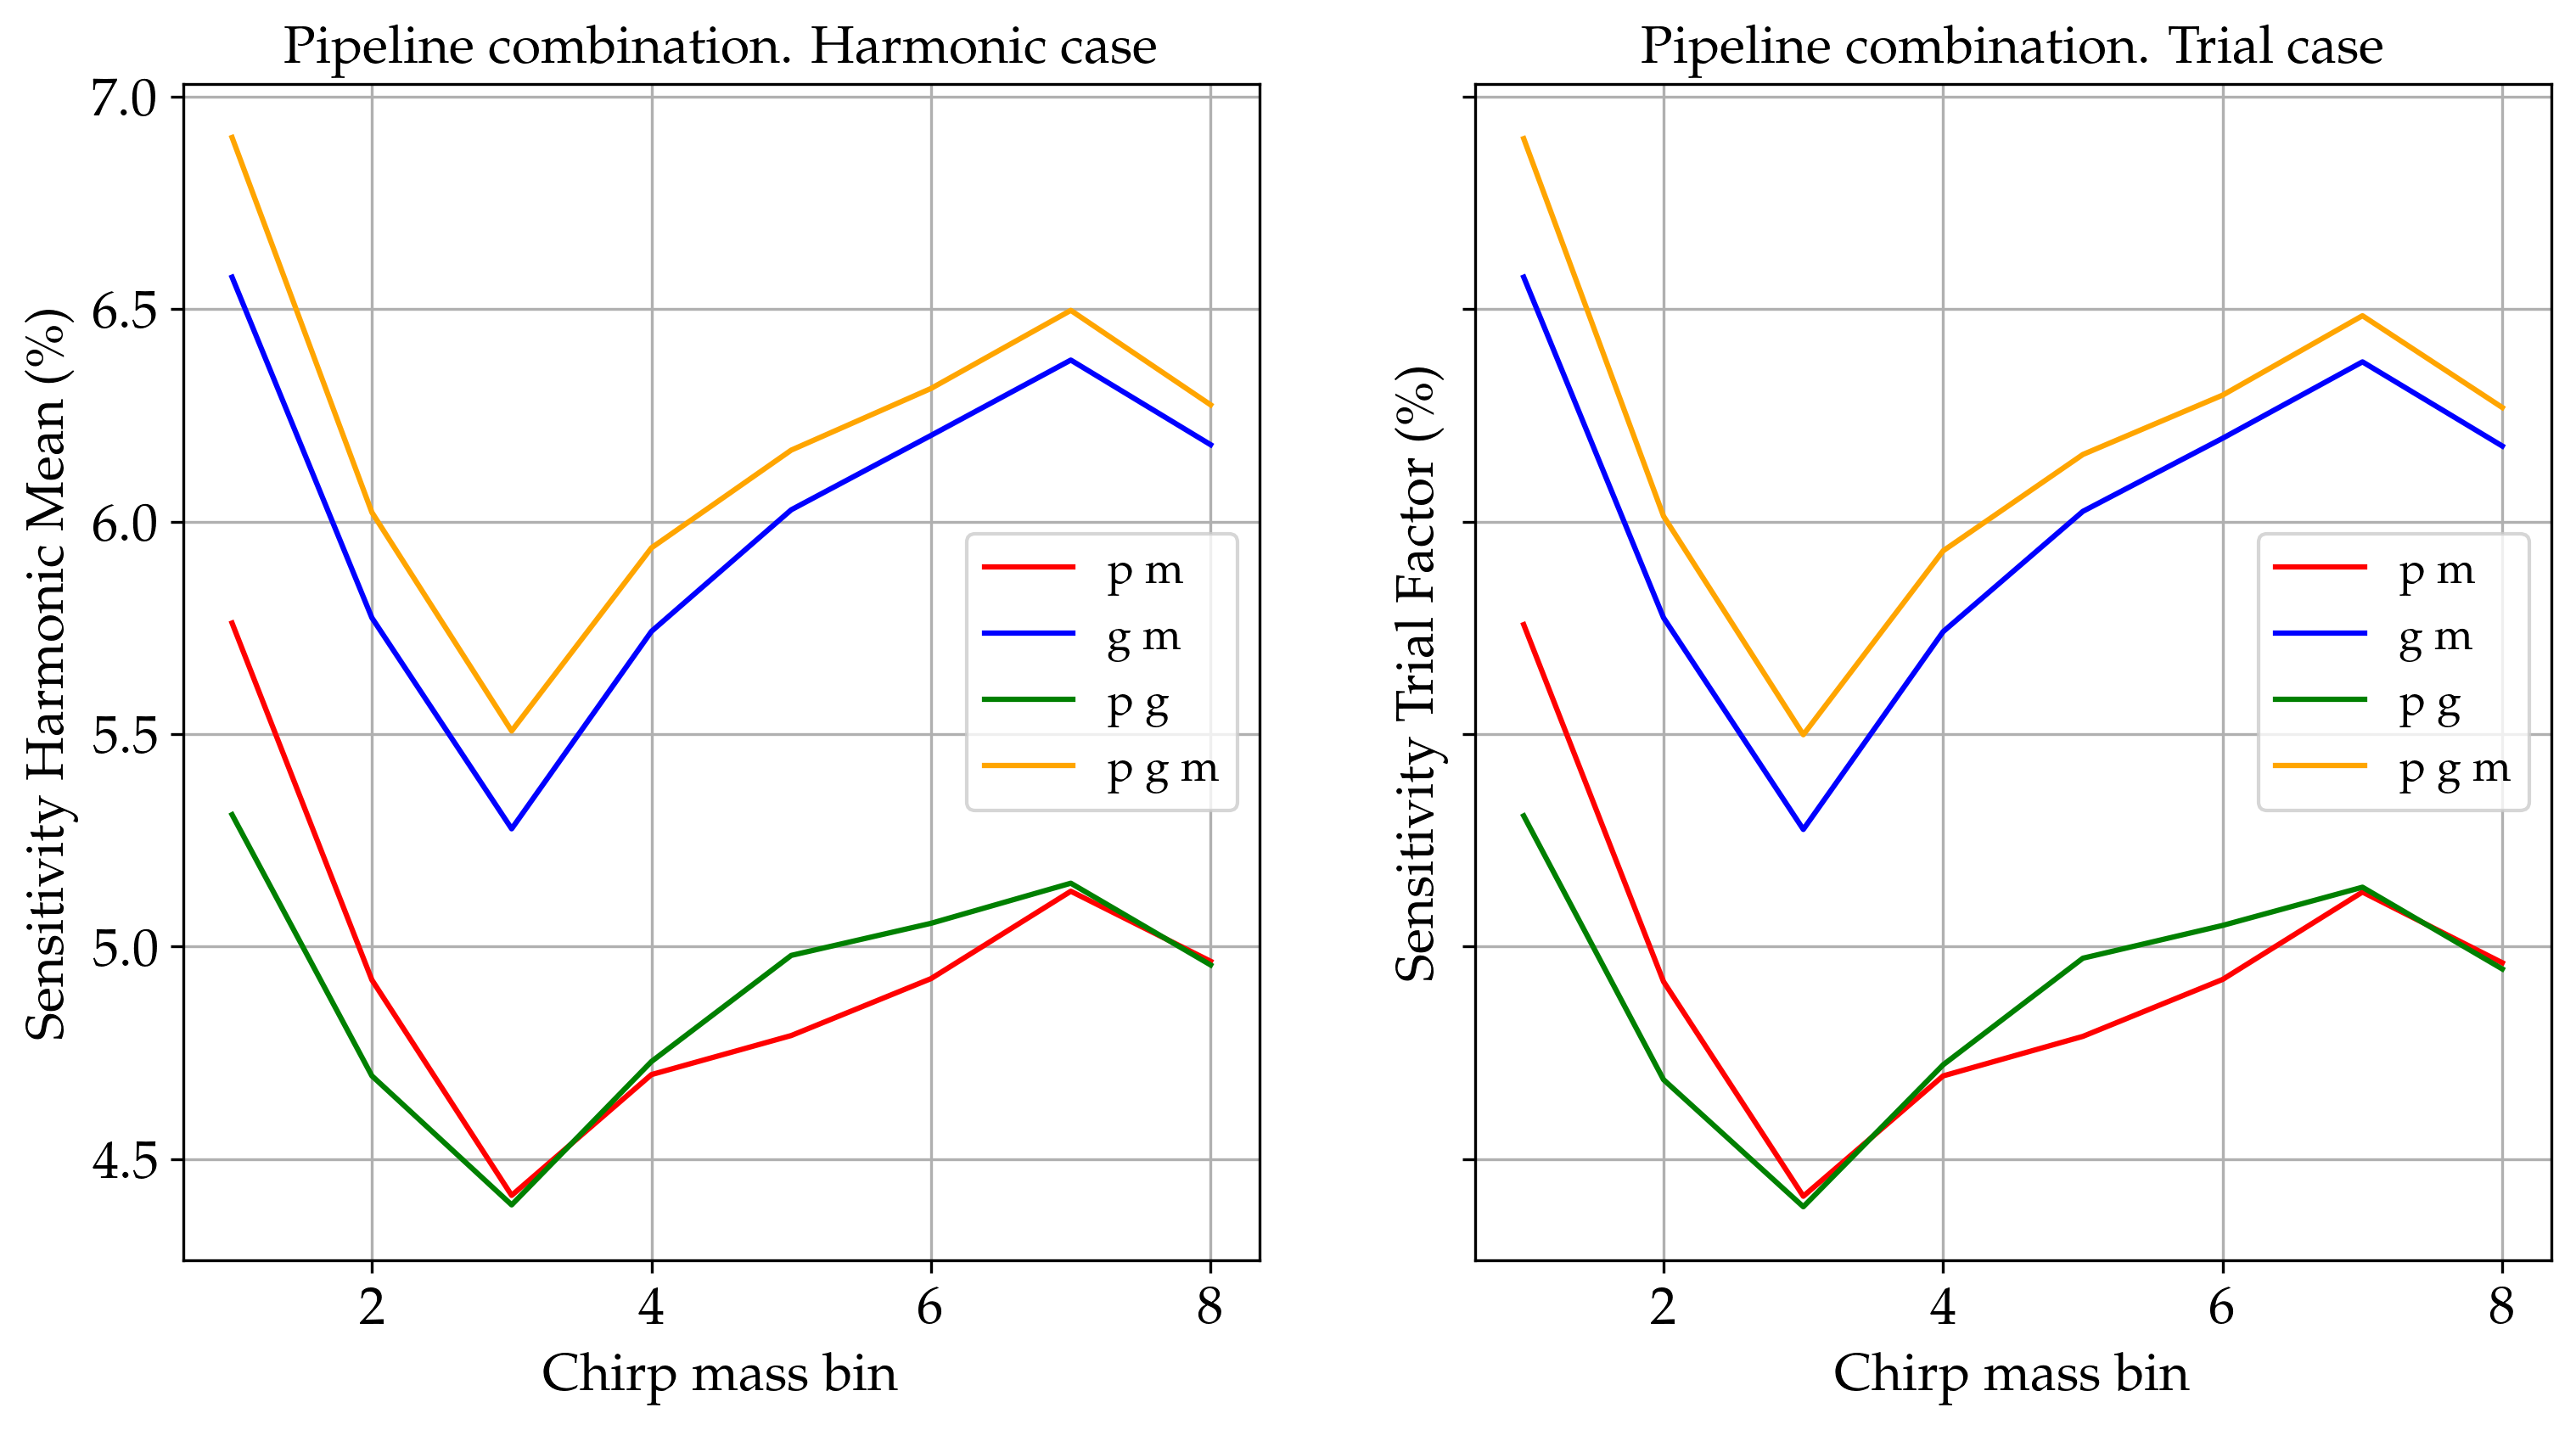

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axs[0].plot(mass, list_har_ifar_mp_found, 'red', label='p m' )
axs[0].plot(mass, list_har_ifar_mg_found, 'blue', label='g m')
axs[0].plot(mass, list_har_ifar_pg_found, 'green', label='p g')
axs[0].plot(mass, list_har_ifar_pgm_found, 'orange', label='p g m')
axs[0].set_xlabel('Chirp mass bin')
axs[0].set_ylabel('Sensitivity Harmonic Mean (\%)')
axs[0].set_title('Pipeline combination. Harmonic case')
axs[0].legend(fontsize='small')
axs[0].grid(True)

axs[1].plot(mass, list_trial_ifar_pm_found, 'red', label='p m' )
axs[1].plot(mass, list_trial_ifar_mg_found, 'blue', label='g m')
axs[1].plot(mass, list_trial_ifar_pg_found, 'green', label='p g')
axs[1].plot(mass, list_trial_ifar_pgm_found, 'orange', label='p g m')
axs[1].set_xlabel('Chirp mass bin ')
axs[1].set_ylabel('Sensitivity Trial Factor (\%)')
axs[1].set_title('Pipeline combination. Trial case')
axs[1].legend(fontsize='small')
axs[1].grid(True)

In [31]:
#compare list 
list_har_ifar_mp_found, list_trial_ifar_pm_found

([5.7612245406726,
  4.921976067270375,
  4.414986385866263,
  4.699151372115795,
  4.790997624082922,
  4.924875408526937,
  5.130386017384803,
  4.965648215382896],
 [5.757485104579563,
  4.917933376455369,
  4.413015703057514,
  4.696012955384267,
  4.789039450667085,
  4.923026870350927,
  5.128516683802224,
  4.962157180360833])

In [32]:
#compare list
list_har_ifar_mg_found, list_trial_ifar_mg_found

([6.574770258980784,
  5.773695480671701,
  5.277236284755302,
  5.741569722569148,
  6.0275834849913394,
  6.202496166718876,
  6.379736795416358,
  6.180653227066729],
 [6.574770258980784,
  5.773695480671701,
  5.27577058935612,
  5.740868076507486,
  6.023929075215062,
  6.195901274462928,
  6.375562258007285,
  6.177527738709173])

In [33]:
#compare list
list_har_ifar_pg_found, list_trial_ifar_pg_found

([5.310498468393205,
  4.696269581877606,
  4.392689111348879,
  4.729796101654482,
  4.979498761155086,
  5.054984914183964,
  5.149291894091986,
  4.957024535083606],
 [5.307713728766361,
  4.687253465569706,
  4.388292025151333,
  4.722077994976214,
  4.9729208235577875,
  5.050038744992004,
  5.139899184921571,
  4.947648070010939])

In [34]:
#compare list
list_har_ifar_pgm_found, list_trial_ifar_pgm_found

([6.9033695349484825,
  6.021638679138961,
  5.507350462426898,
  5.938030619834131,
  6.167912820400377,
  6.312960612006001,
  6.496623842870412,
  6.274417877793405],
 [6.900584795321637,
  6.01262256283106,
  5.4985562900318055,
  5.931014159217525,
  6.157680473026801,
  6.297297742898126,
  6.484100230643191,
  6.268166901078294])

In [35]:
list_found_gm_and_df = []
list_found_gp_and_df = []
list_found_mp_and_df = []
list_found_mpg_and_df = []

list_found_gm_or_df = []
list_found_gp_or_df = []
list_found_mp_or_df = []
list_found_mpg_or_df = []

list_found_gm_and_df_g = []
list_found_gp_and_df_g = []
list_found_mp_and_df_g = []
list_found_mpg_and_df_g = []

list_found_gm_or_df_g = []
list_found_gp_or_df_g = []
list_found_mp_or_df_g = []
list_found_mpg_or_df_g = []

def values_and_or(df, df_g, ifar_threshold):
    pfound_df = (df['pycbc_ifar'] >= ifar_threshold)
    mfound_df = (df['mbta_ifar'] >= ifar_threshold)
    gfound_df = (df['gstlal_ifar'] >= ifar_threshold)  
    
    found_gm_and_df = (mfound_df * gfound_df) 
    found_gp_and_df = (pfound_df * gfound_df) 
    found_mp_and_df = (pfound_df * mfound_df) 
    found_mpg_and_df = (pfound_df * mfound_df * gfound_df)
    
    found_gm_or_df = np.logical_or(mfound_df, gfound_df) 
    found_gp_or_df = np.logical_or(pfound_df, gfound_df) 
    found_mp_or_df = np.logical_or(pfound_df, mfound_df)
    found_mpg_or_df = np.logical_or(pfound_df, mfound_df, gfound_df)
    
    found_gm_and_df = found_gm_and_df.sum()*(100/len(found_gm_and_df))
    found_gp_and_df = found_gp_and_df.sum()*(100/len(found_gp_and_df))
    found_mp_and_df = found_mp_and_df.sum()*(100/len(found_mp_and_df))
    found_mpg_and_df = found_mpg_and_df.sum()*(100/len(found_mpg_and_df))
    
    found_gm_or_df = found_gm_or_df.sum()*(100/len(found_gm_or_df))                       
    found_gp_or_df = found_gp_or_df.sum()*(100/len(found_gp_or_df))
    found_mp_or_df = found_mp_or_df.sum()*(100/len(found_mp_or_df))
    found_mpg_or_df = found_mpg_or_df.sum()*(100/len(found_mpg_or_df))
    
    #print('pfound =',pfound.sum()*(100/len(df)), ', mfound =',mfound.sum()*(100/len(df)), ', gfound =',gfound.sum()*(100/len(df)))
    #print('***************************************\n')
    #print('analysis with AND')
    #print('found_gm_and =',found_gm_and, ', found_gp_and =',found_gp_and, ', found_mp_and =',found_mp_and, ', found_mpg_and =', found_mpg_and, '\n')
    #print('analysis with OR')
    #print('found_gm_or =',found_gm_or, ', found_gp_or =',found_gp_or, ', found_mp_or =',found_mp_or, ', found_mpg_or =', found_mpg_or)
    
    list_found_gm_and_df.append(found_gm_and_df)
    list_found_gp_and_df.append(found_gp_and_df)
    list_found_mp_and_df.append(found_mp_and_df)
    list_found_mpg_and_df.append(found_mpg_and_df)
    
    list_found_gm_or_df.append(found_gm_or_df)
    list_found_gp_or_df.append(found_gp_or_df)
    list_found_mp_or_df.append(found_mp_or_df)
    list_found_mpg_or_df.append(found_mpg_or_df)
    
    #for df_g
    pfound_df_g = (df_g['pycbc_ifar'] >= ifar_threshold)
    mfound_df_g = (df_g['mbta_ifar'] >= ifar_threshold)
    gfound_df_g = (df_g['gstlal_ifar'] >= ifar_threshold)
    
    found_gm_and_df_g = (mfound_df_g * gfound_df_g) 
    found_gp_and_df_g = (pfound_df_g * gfound_df_g) 
    found_mp_and_df_g = (pfound_df_g * mfound_df_g) 
    found_mpg_and_df_g = (pfound_df_g * mfound_df_g * gfound_df_g)
    
    found_gm_or_df_g = np.logical_or(mfound_df_g, gfound_df_g) 
    found_gp_or_df_g = np.logical_or(pfound_df_g, gfound_df_g) 
    found_mp_or_df_g = np.logical_or(pfound_df_g, mfound_df_g)
    found_mpg_or_df_g = np.logical_or(pfound_df_g, mfound_df_g, gfound_df_g)
    
    found_gm_and_df_g = found_gm_and_df_g.sum()*(100/len(found_gm_and_df_g))
    found_gp_and_df_g = found_gp_and_df_g.sum()*(100/len(found_gp_and_df_g))
    found_mp_and_df_g = found_mp_and_df_g.sum()*(100/len(found_mp_and_df_g))
    found_mpg_and_df_g = found_mpg_and_df_g.sum()*(100/len(found_mpg_and_df_g))
    
    found_gm_or_df_g = found_gm_or_df_g.sum()*(100/len(found_gm_or_df_g))                       
    found_gp_or_df_g = found_gp_or_df_g.sum()*(100/len(found_gp_or_df_g))
    found_mp_or_df_g = found_mp_or_df_g.sum()*(100/len(found_mp_or_df_g))
    found_mpg_or_df_g = found_mpg_or_df_g.sum()*(100/len(found_mpg_or_df_g))
    
    list_found_gm_and_df_g.append(found_gm_and_df_g)
    list_found_gp_and_df_g.append(found_gp_and_df_g)
    list_found_mp_and_df_g.append(found_mp_and_df_g)
    list_found_mpg_and_df_g.append(found_mpg_and_df_g)
    
    list_found_gm_or_df_g.append(found_gm_or_df_g)
    list_found_gp_or_df_g.append(found_gp_or_df_g)
    list_found_mp_or_df_g.append(found_mp_or_df_g)
    list_found_mpg_or_df_g.append(found_mpg_or_df_g)
    
    return list_found_gm_and_df, list_found_gp_and_df, list_found_mp_and_df, list_found_mpg_and_df, list_found_gm_or_df, list_found_gp_or_df, list_found_mp_or_df, list_found_mpg_or_df, list_found_gm_and_df_g, list_found_gp_and_df_g, list_found_mp_and_df_g, list_found_mpg_and_df_g, list_found_gm_or_df_g, list_found_gp_or_df_g, list_found_mp_or_df_g, list_found_mpg_or_df_g

In [36]:
values_and_or(df_1, df_g_1, 10) 

([0.877521003166056],
 [1.4920350011218309],
 [2.0330067559145415],
 [0.7927604517238801],
 [5.230224615461323],
 [4.633161319273054],
 [5.9444569092314214],
 [5.9444569092314214],
 [1.9604566972988025],
 [3.338902812587023],
 [2.018936229462545],
 [1.77109440267335],
 [6.747424115845168],
 [5.463659147869674],
 [5.984405458089668],
 [5.984405458089668])

In [37]:
values_and_or(df_2, df_g_2, 10)

([0.877521003166056, 0.7751859637774903],
 [1.4920350011218309, 1.3032624514877102],
 [2.0330067559145415, 1.7034888421733507],
 [0.7927604517238801, 0.6746240297542044],
 [5.230224615461323, 4.519728331177232],
 [4.633161319273054, 4.012875970245796],
 [5.9444569092314214, 5.061954236739974],
 [5.9444569092314214, 5.061954236739974],
 [1.9604566972988025, 1.7299673165783838],
 [3.338902812587023, 2.9065704947593822],
 [2.018936229462545, 1.6533303279612306],
 [1.77109440267335, 1.505691423419362],
 [6.747424115845168, 5.923588414290544],
 [5.463659147869674, 4.810098050264848],
 [5.984405458089668, 5.133551222810774],
 [5.984405458089668, 5.133551222810774])

In [38]:
values_and_or(df_3, df_g_3, 10)

([0.877521003166056, 0.7751859637774903, 0.6864545117140671],
 [1.4920350011218309, 1.3032624514877102, 1.2050725375497187],
 [2.0330067559145415, 1.7034888421733507, 1.470457822461186],
 [0.7927604517238801, 0.6746240297542044, 0.6105832235772491],
 [5.230224615461323, 4.519728331177232, 4.041541993608419],
 [4.633161319273054, 4.012875970245796, 3.709481940334294],
 [5.9444569092314214, 5.061954236739974, 4.546693686917623],
 [5.9444569092314214, 5.061954236739974, 4.546693686917623],
 [1.9604566972988025, 1.7299673165783838, 1.5323845398449294],
 [3.338902812587023, 2.9065704947593822, 2.6888182097996394],
 [2.018936229462545, 1.6533303279612306, 1.4788866577747812],
 [1.77109440267335, 1.505691423419362, 1.363096721239392],
 [6.747424115845168, 5.923588414290544, 5.413545956879241],
 [5.463659147869674, 4.810098050264848, 4.49528778929163],
 [5.984405458089668, 5.133551222810774, 4.564908320752781],
 [5.984405458089668, 5.133551222810774, 4.564908320752781])

In [39]:
values_and_or(df_4, df_g_4, 10)

([0.877521003166056,
  0.7751859637774903,
  0.6864545117140671,
  0.7434909236988124],
 [1.4920350011218309,
  1.3032624514877102,
  1.2050725375497187,
  1.3203319189535263],
 [2.0330067559145415,
  1.7034888421733507,
  1.470457822461186,
  1.5541439654523086],
 [0.7927604517238801,
  0.6746240297542044,
  0.6105832235772491,
  0.649338421752994],
 [5.230224615461323, 4.519728331177232, 4.041541993608419, 4.355494740013558],
 [4.633161319273054, 4.012875970245796, 3.709481940334294, 3.9578573401290518],
 [5.9444569092314214, 5.061954236739974, 4.546693686917623, 4.839124758341912],
 [5.9444569092314214, 5.061954236739974, 4.546693686917623, 4.839124758341912],
 [1.9604566972988025,
  1.7299673165783838,
  1.5323845398449294,
  1.6629011661357544],
 [3.338902812587023,
  2.9065704947593822,
  2.6888182097996394,
  2.9532282735297004],
 [2.018936229462545,
  1.6533303279612306,
  1.4788866577747812,
  1.541516397468461],
 [1.77109440267335, 1.505691423419362, 1.363096721239392, 1.4524

In [40]:
values_and_or(df_5, df_g_5, 10)

([0.877521003166056,
  0.7751859637774903,
  0.6864545117140671,
  0.7434909236988124,
  0.8175374011122425],
 [1.4920350011218309,
  1.3032624514877102,
  1.2050725375497187,
  1.3203319189535263,
  1.415433017414689],
 [2.0330067559145415,
  1.7034888421733507,
  1.470457822461186,
  1.5541439654523086,
  1.6709746481815095],
 [0.7927604517238801,
  0.6746240297542044,
  0.6105832235772491,
  0.649338421752994,
  0.7202814547923031],
 [5.230224615461323,
  4.519728331177232,
  4.041541993608419,
  4.355494740013558,
  4.5256651262369125],
 [4.633161319273054,
  4.012875970245796,
  3.709481940334294,
  3.9578573401290518,
  4.105963290775698],
 [5.9444569092314214,
  5.061954236739974,
  4.546693686917623,
  4.839124758341912,
  4.924153416359887],
 [5.9444569092314214,
  5.061954236739974,
  4.546693686917623,
  4.839124758341912,
  4.924153416359887],
 [1.9604566972988025,
  1.7299673165783838,
  1.5323845398449294,
  1.6629011661357544,
  1.8286666520490276],
 [3.338902812587023,


In [41]:
values_and_or(df_6, df_g_6, 10)

([0.877521003166056,
  0.7751859637774903,
  0.6864545117140671,
  0.7434909236988124,
  0.8175374011122425,
  0.8529155144112037],
 [1.4920350011218309,
  1.3032624514877102,
  1.2050725375497187,
  1.3203319189535263,
  1.415433017414689,
  1.4411203620177164],
 [2.0330067559145415,
  1.7034888421733507,
  1.470457822461186,
  1.5541439654523086,
  1.6709746481815095,
  1.7261649487585218],
 [0.7927604517238801,
  0.6746240297542044,
  0.6105832235772491,
  0.649338421752994,
  0.7202814547923031,
  0.7501367918250248],
 [5.230224615461323,
  4.519728331177232,
  4.041541993608419,
  4.355494740013558,
  4.5256651262369125,
  4.671625678413511],
 [4.633161319273054,
  4.012875970245796,
  3.709481940334294,
  3.9578573401290518,
  4.105963290775698,
  4.145531713520948],
 [5.9444569092314214,
  5.061954236739974,
  4.546693686917623,
  4.839124758341912,
  4.924153416359887,
  5.060927818281304],
 [5.9444569092314214,
  5.061954236739974,
  4.546693686917623,
  4.839124758341912,
  4

In [42]:
values_and_or(df_7, df_g_7, 10)

([0.877521003166056,
  0.7751859637774903,
  0.6864545117140671,
  0.7434909236988124,
  0.8175374011122425,
  0.8529155144112037,
  0.8972801196373493],
 [1.4920350011218309,
  1.3032624514877102,
  1.2050725375497187,
  1.3203319189535263,
  1.415433017414689,
  1.4411203620177164,
  1.4520048602673148],
 [2.0330067559145415,
  1.7034888421733507,
  1.470457822461186,
  1.5541439654523086,
  1.6709746481815095,
  1.7261649487585218,
  1.8763435835124778],
 [0.7927604517238801,
  0.6746240297542044,
  0.6105832235772491,
  0.649338421752994,
  0.7202814547923031,
  0.7501367918250248,
  0.7846527712870361],
 [5.230224615461323,
  4.519728331177232,
  4.041541993608419,
  4.355494740013558,
  4.5256651262369125,
  4.671625678413511,
  4.9579399943919995],
 [4.633161319273054,
  4.012875970245796,
  3.709481940334294,
  3.9578573401290518,
  4.105963290775698,
  4.145531713520948,
  4.278904570520609],
 [5.9444569092314214,
  5.061954236739974,
  4.546693686917623,
  4.839124758341912,


In [43]:
values_and_or(df_8, df_g_8, 10)

([0.877521003166056,
  0.7751859637774903,
  0.6864545117140671,
  0.7434909236988124,
  0.8175374011122425,
  0.8529155144112037,
  0.8972801196373493,
  0.9188404178070715],
 [1.4920350011218309,
  1.3032624514877102,
  1.2050725375497187,
  1.3203319189535263,
  1.415433017414689,
  1.4411203620177164,
  1.4520048602673148,
  1.4110763559180026],
 [2.0330067559145415,
  1.7034888421733507,
  1.470457822461186,
  1.5541439654523086,
  1.6709746481815095,
  1.7261649487585218,
  1.8763435835124778,
  1.8998212590068704],
 [0.7927604517238801,
  0.6746240297542044,
  0.6105832235772491,
  0.649338421752994,
  0.7202814547923031,
  0.7501367918250248,
  0.7846527712870361,
  0.8050326760878066],
 [5.230224615461323,
  4.519728331177232,
  4.041541993608419,
  4.355494740013558,
  4.5256651262369125,
  4.671625678413511,
  4.9579399943919995,
  4.802267776350333],
 [4.633161319273054,
  4.012875970245796,
  3.709481940334294,
  3.9578573401290518,
  4.105963290775698,
  4.145531713520948

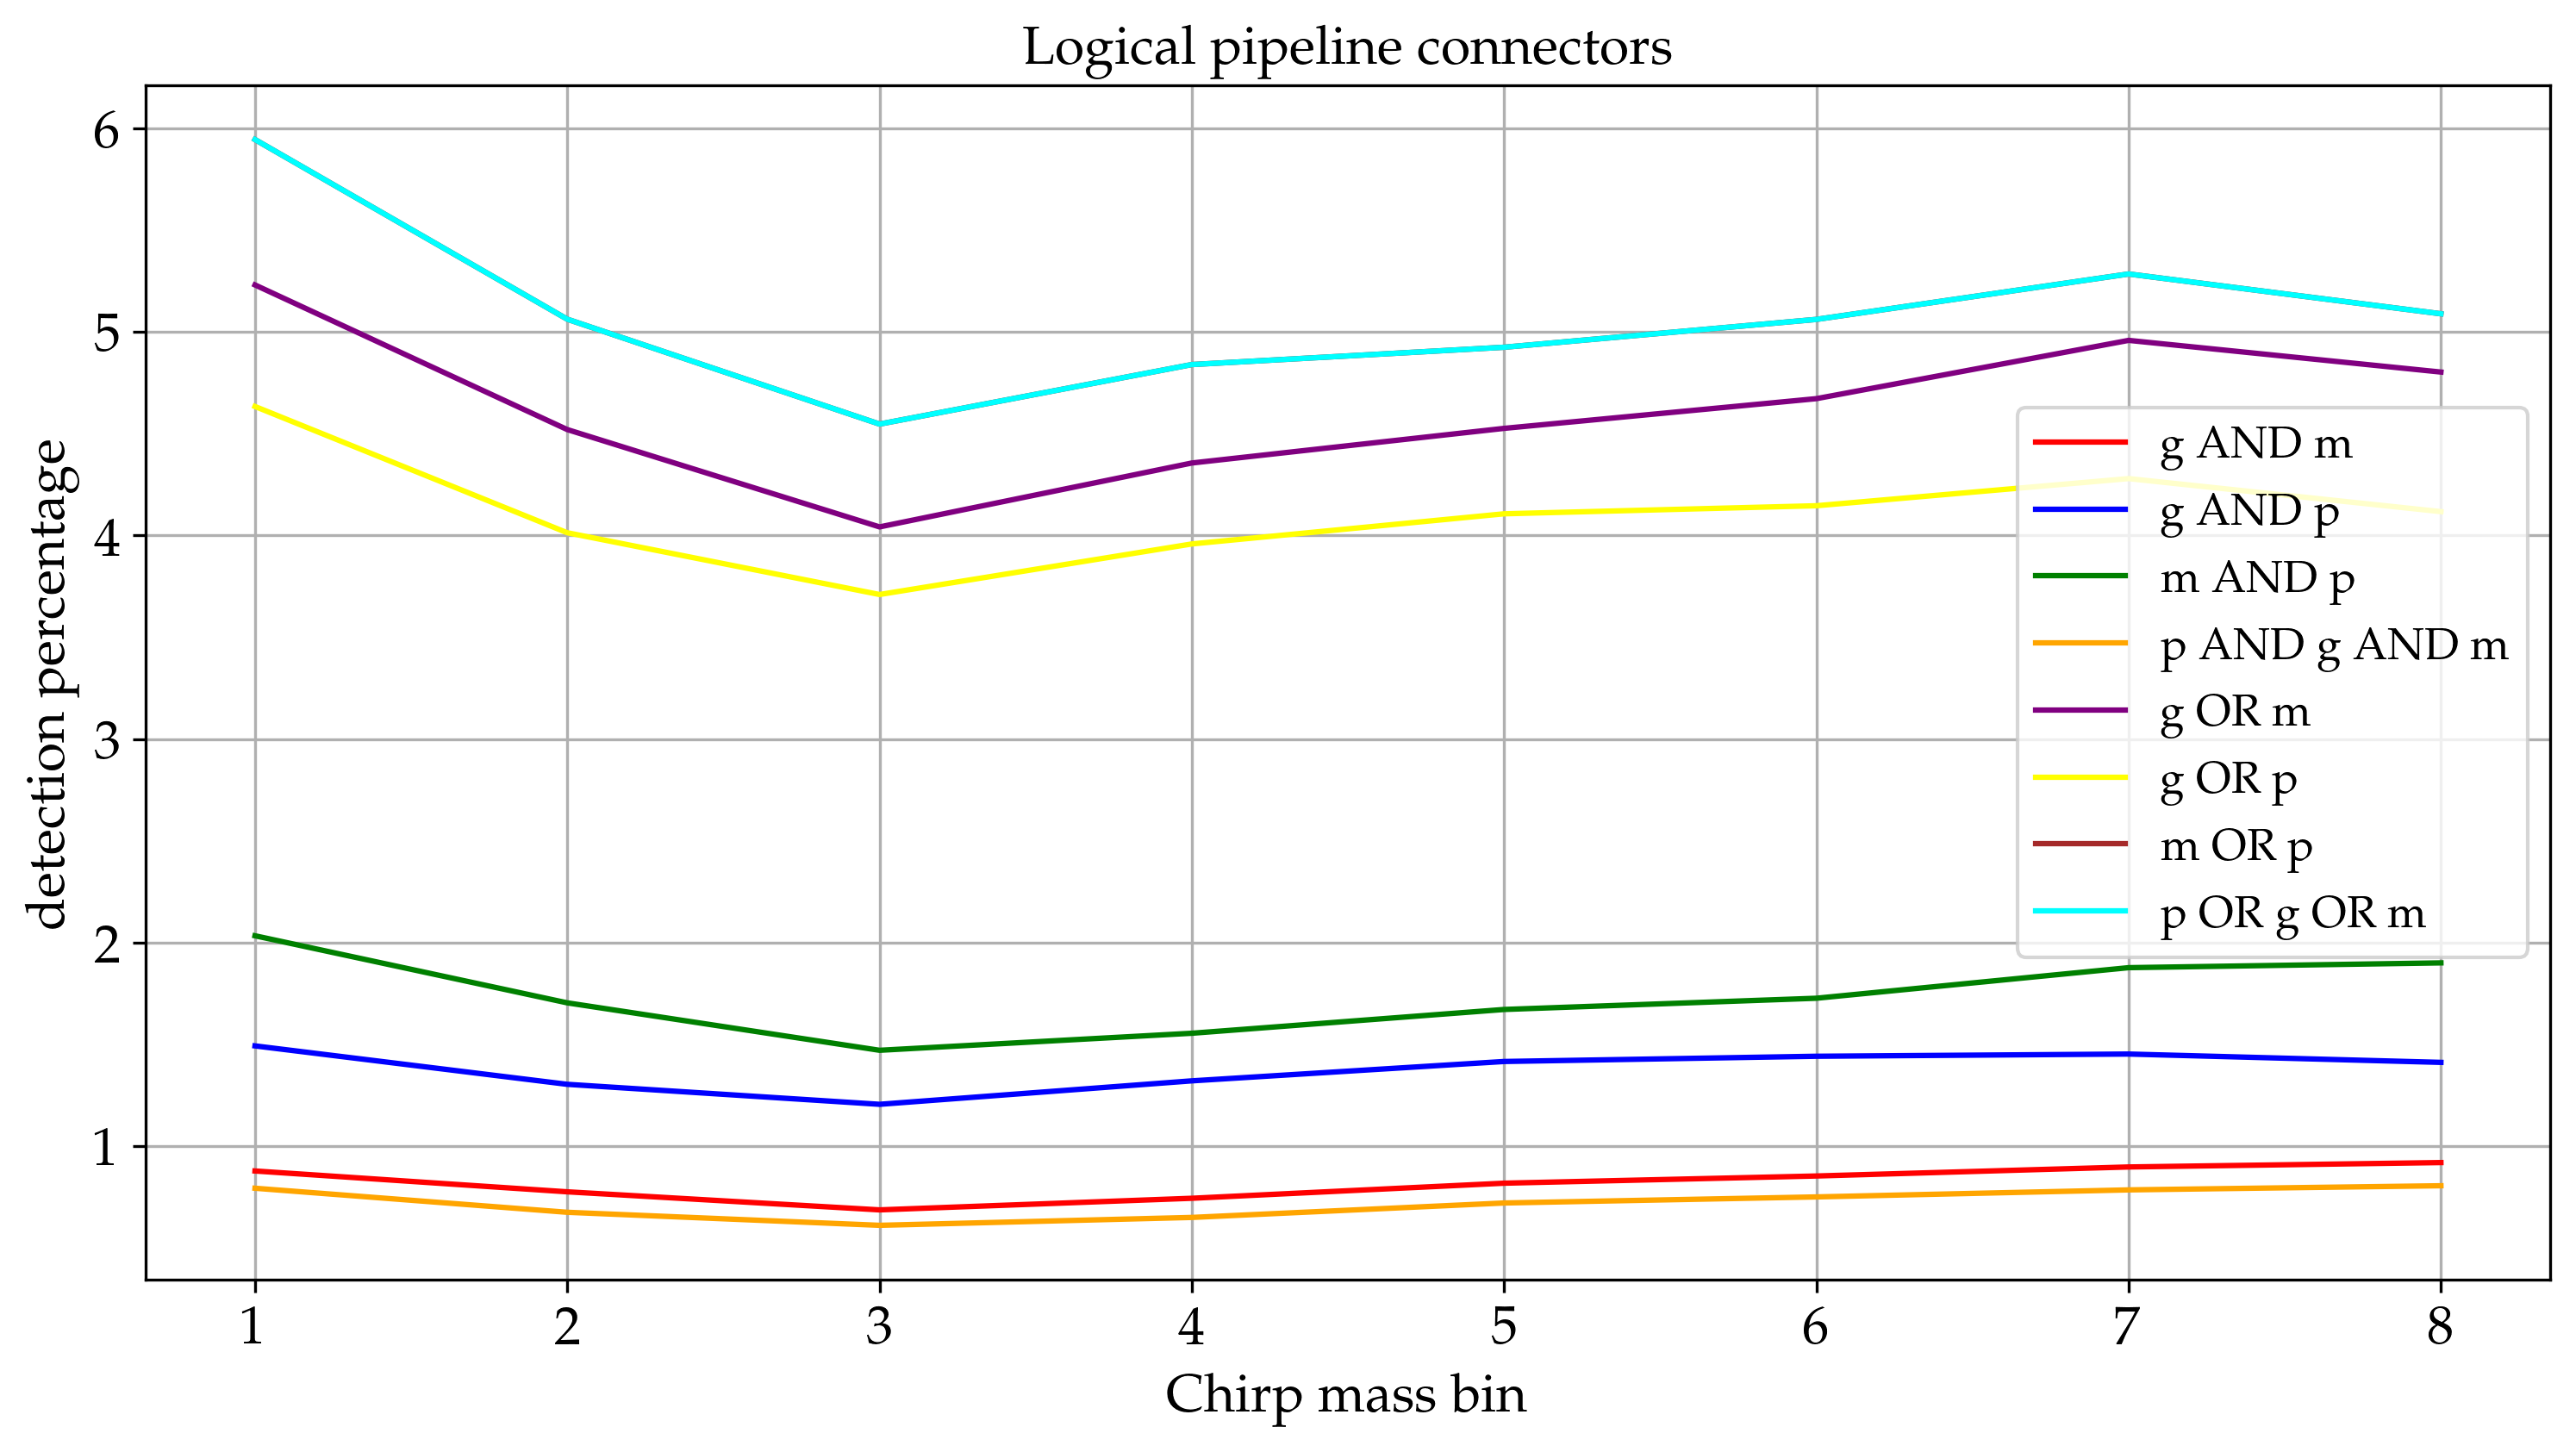

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharey=True)

axs.plot(mass, list_found_gm_and_df, 'red', label='g AND m' ) 
axs.plot(mass, list_found_gp_and_df, 'blue', label='g AND p')
axs.plot(mass, list_found_mp_and_df, 'green', label='m AND p')
axs.plot(mass, list_found_mpg_and_df, 'orange', label='p AND g AND m')
axs.plot(mass, list_found_gm_or_df, 'purple', label='g OR m')
axs.plot(mass, list_found_gp_or_df, 'yellow', label='g OR p')
axs.plot(mass, list_found_mp_or_df, 'brown', label='m OR p')
axs.plot(mass, list_found_mpg_or_df, 'cyan', label='p OR g OR m')
axs.set_xlabel('Chirp mass bin')
axs.set_ylabel('detection percentage ')
axs.set_title('Logical pipeline connectors') 
axs.legend(fontsize='small')
axs.grid(True)

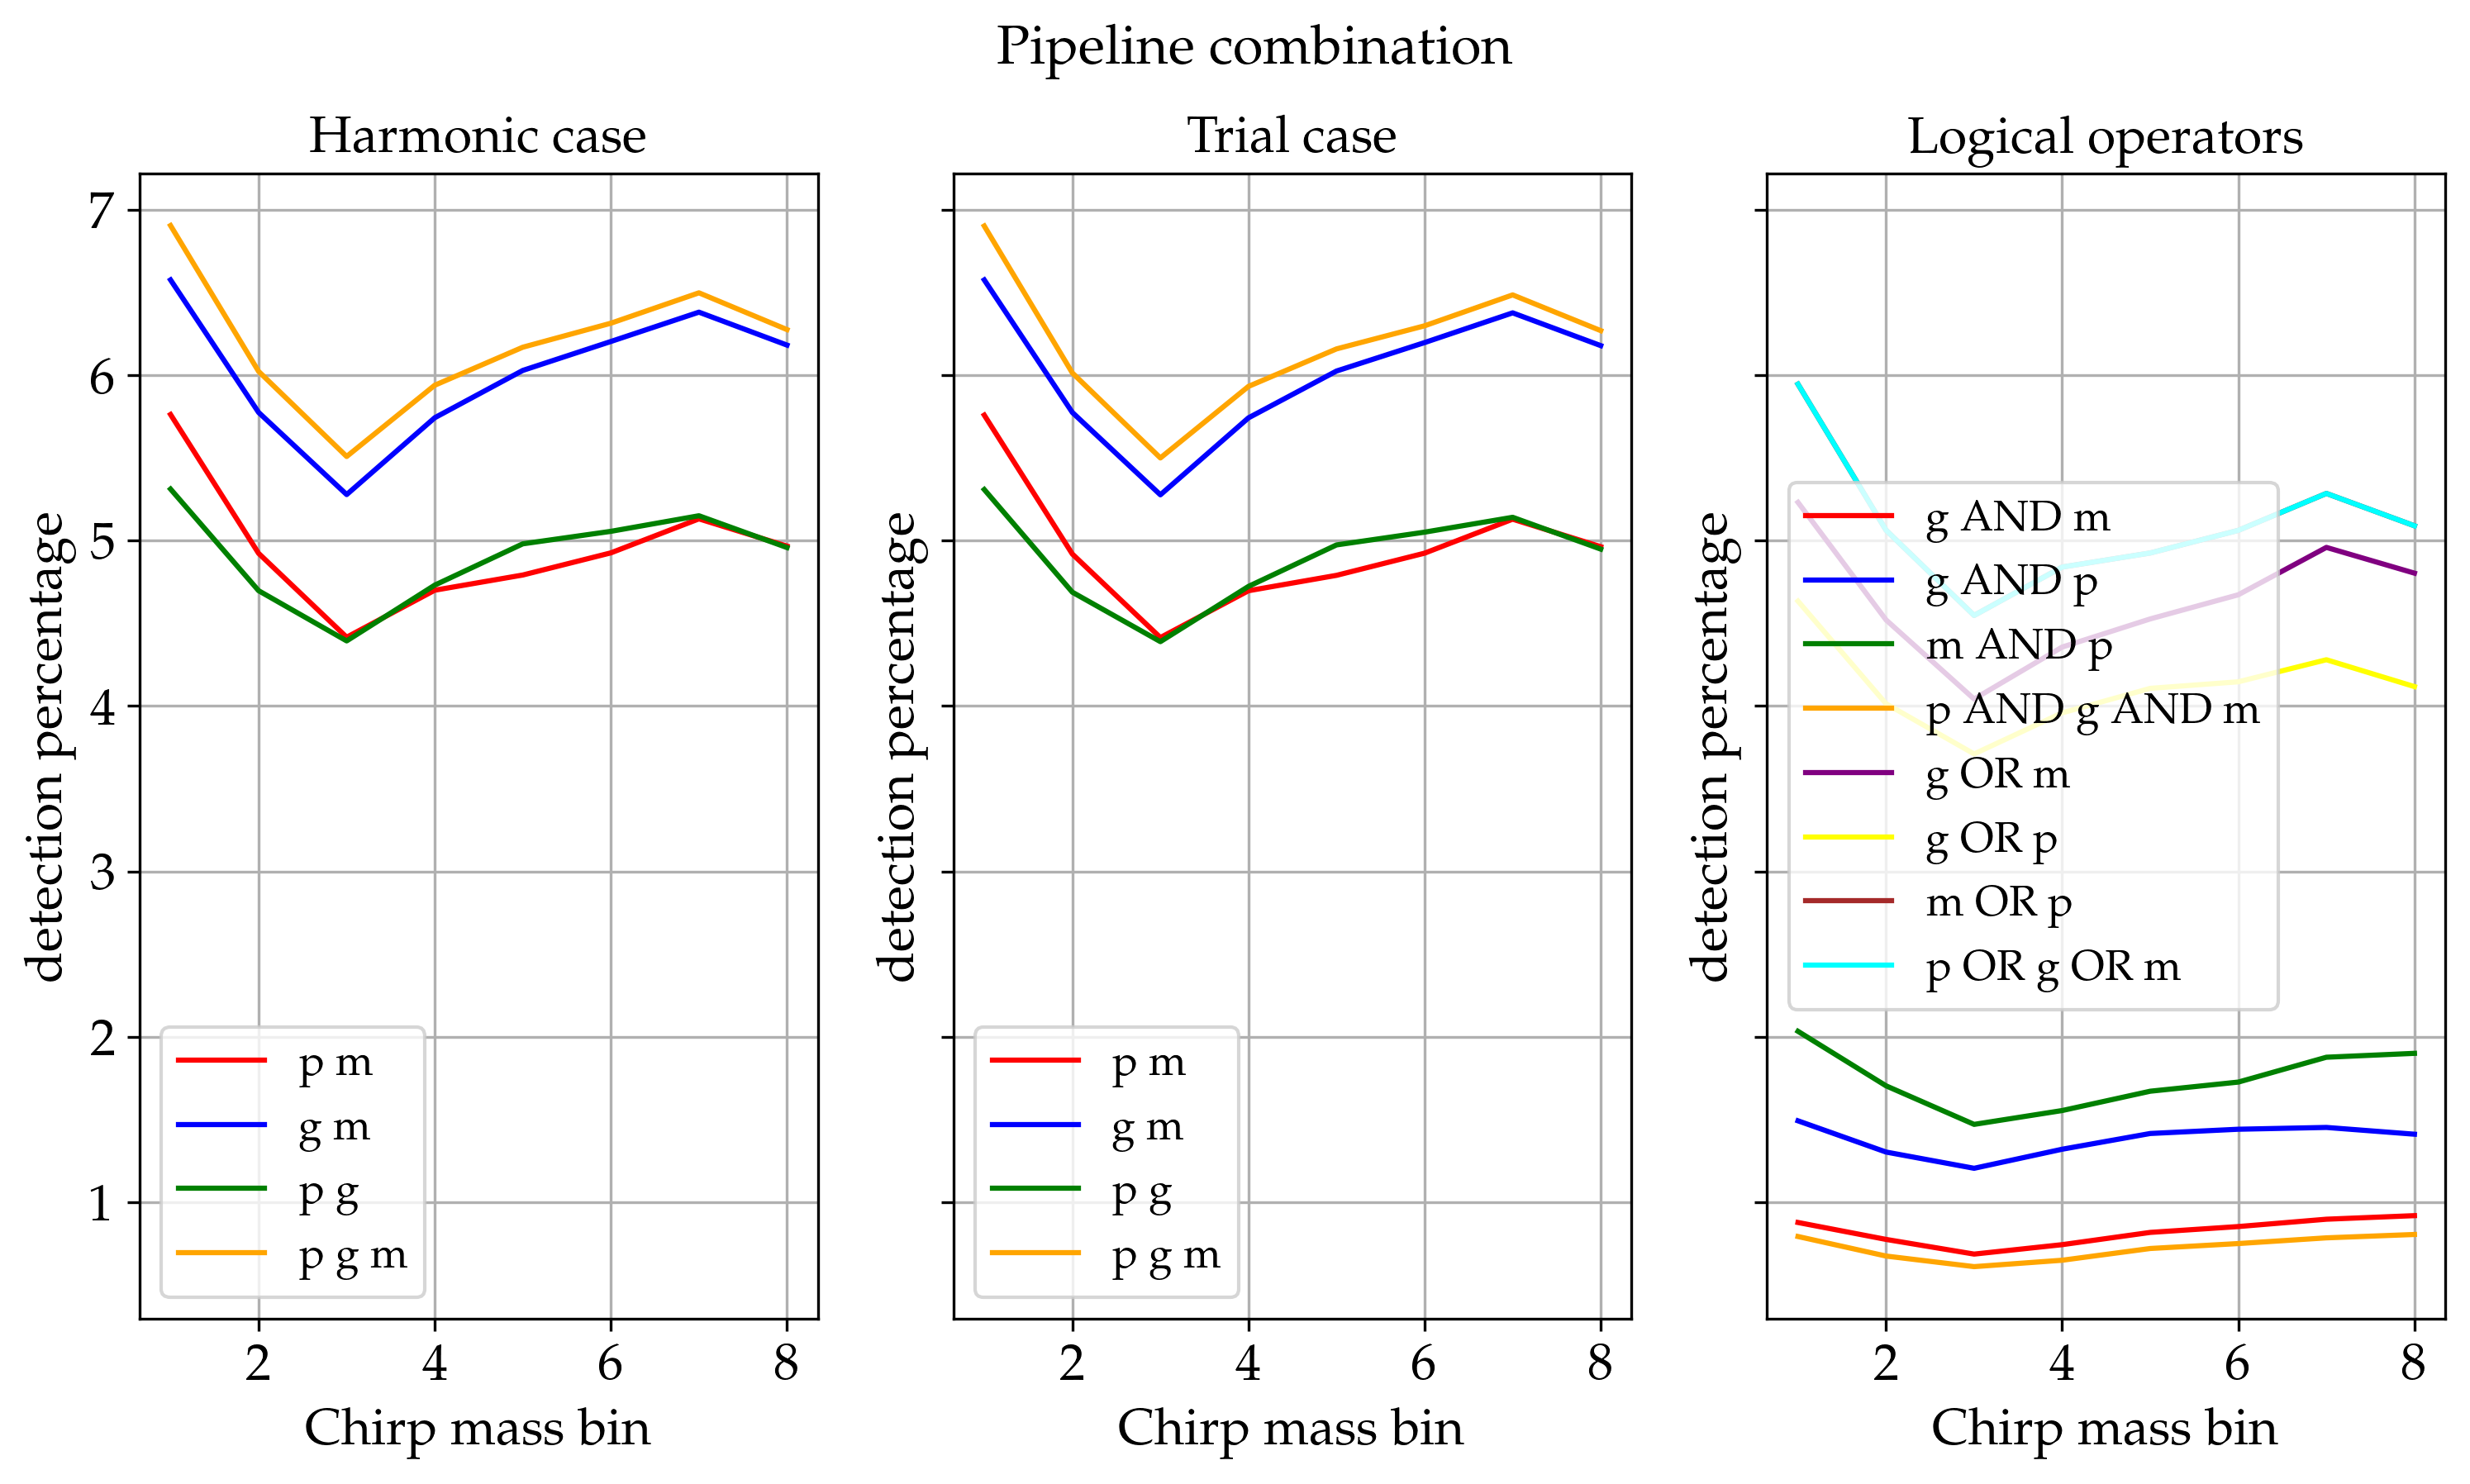

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

fig.suptitle('Pipeline combination', fontsize=16)
axs[0].plot(mass, list_har_ifar_mp_found, 'red', label='p m' )
axs[0].plot(mass, list_har_ifar_mg_found, 'blue', label='g m')
axs[0].plot(mass, list_har_ifar_pg_found, 'green', label='p g')
axs[0].plot(mass, list_har_ifar_pgm_found, 'orange', label='p g m')
axs[0].set_xlabel('Chirp mass bin')
axs[0].set_ylabel('detection percentage')
axs[0].set_title('Harmonic case')
axs[0].legend(fontsize='small')
axs[0].grid(True)
 
axs[1].plot(mass, list_trial_ifar_pm_found, 'red', label='p m' )
axs[1].plot(mass, list_trial_ifar_mg_found, 'blue', label='g m')
axs[1].plot(mass, list_trial_ifar_pg_found, 'green', label='p g')
axs[1].plot(mass, list_trial_ifar_pgm_found, 'orange', label='p g m')
axs[1].set_xlabel('Chirp mass bin ')
axs[1].set_ylabel('detection percentage ')
axs[1].set_title('Trial case')
axs[1].legend(fontsize='small')
axs[1].grid(True)

axs[2].plot(mass, list_found_gm_and_df, 'red', label='g AND m' ) 
axs[2].plot(mass, list_found_gp_and_df, 'blue', label='g AND p')
axs[2].plot(mass, list_found_mp_and_df, 'green', label='m AND p')
axs[2].plot(mass, list_found_mpg_and_df, 'orange', label='p AND g AND m')
axs[2].plot(mass, list_found_gm_or_df, 'purple', label='g OR m')
axs[2].plot(mass, list_found_gp_or_df, 'yellow', label='g OR p')
axs[2].plot(mass, list_found_mp_or_df, 'brown', label='m OR p')
axs[2].plot(mass, list_found_mpg_or_df, 'cyan', label='p OR g OR m')
axs[2].set_xlabel('Chirp mass bin')
axs[2].set_ylabel('detection percentage ')
axs[2].set_title('Logical operators') 
axs[2].legend(fontsize='small')
axs[2].grid(True)

In [46]:
injection_file1 = '/home/pycbc.offline/O3/production/O3A_SUB_SOLAR/sub_solar/STATMAP/H1L1V1-COMBINE_STATMAP_FULL_DATA-1238165866-622112.hdf'
injections1 = load_dict_from_hdf5(injection_file1)
injections1.keys(), len(injections1.keys())

(dict_keys(['H1L1', 'H1L1V1', 'H1V1', 'L1V1', 'background', 'background_exc', 'background_h0', 'foreground', 'foreground_h0', 'segments']),
 10)